# Chapter 10: Statistics - The Monte Carlo Method


In this chapter, we take a brief look at the Monte Carlo Method. We start by introducing the Linear Congruential Generator (LCG) to generate random numbers.

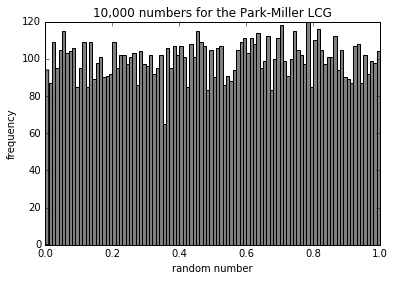

In [23]:
import numpy as np
import pylab as pl
%matplotlib inline

#Define a function that returns LCG (pseudo) random numbers
def LCG (a=16807,b=0,M=2147483647):
    N1 = (a*LCG.seed+b) % M
    LCG.seed = N1
    return N1/M

#Initialize the seed:
LCG.seed=10135

#Generate an array of random numbers from the the LCG
nr=10000
r=np.zeros(nr)
for i in range(nr):
    r[i] = LCG()

#Plot a histogram of the values:
pl.hist(r,bins=100,color='gray')
pl.xlabel('random number')
pl.ylabel('frequency')
pl.title('10,000 numbers for the Park-Miller LCG')
pl.show()

We can then use this LCG to generate numbers that are exponentially distributed with a time constant $\tau$:


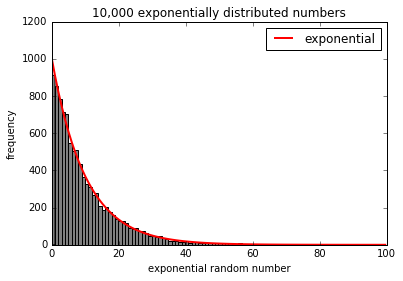

In [26]:
#using the array of values, r, we transform these into values y:
tau = 10
y = -tau * np.log(r) #numpy log is really ln
#Plot a histogram of the values:
n,bins,patches=pl.hist(y,bins=100,color='gray')
pl.xlabel('exponential random number')
pl.ylabel('frequency')
pl.title('10,000 exponentially distributed numbers')
#plot the corresponding exponential (normalized by the number of y values)
xi=np.linspace(0,y.max(),100)
norm = y.size/(bins[1]-bins[0])/tau
pl.plot(xi,norm*np.exp(-xi/tau),color='red',lw=2,label="exponential")
pl.legend()
pl.show()

The numpy.random module has a functions to generate random numbers from a variety of distributions, a few are illustrated below:

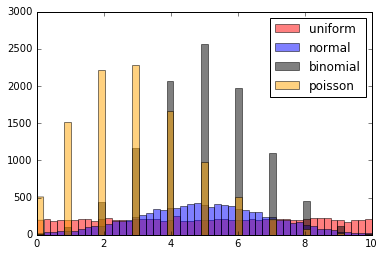

In [45]:
nr = 10000 # number of random numbers to generate
#Uniform distribution:
xmin=0
xmax=10
xunif = np.random.uniform(xmin,xmax,nr)
#Normal distribution:
mu = 5
sigma = 2
xnorm = np.random.normal(mu,sigma,nr)
#Binomial distribution:
N=10
p=0.5
xbinom = np.random.binomial(N,p,nr)
#Poisson distribution:
n=3
xpoiss = np.random.poisson(n,nr)
#Plot them all:
bins = np.linspace(0,10,50)
pl.hist(xunif,bins=bins,color='red',alpha=0.5,label='uniform')
pl.hist(xnorm,bins=bins,color='blue',alpha=0.5,label='normal')
pl.hist(xbinom,bins=bins,color='black',alpha=0.5,label='binomial')
pl.hist(xpoiss,bins=bins,color='orange',alpha=0.5,label='poisson')
pl.legend()
pl.show()

## 10.2 Monte Carlo Simulations
### Simulating coin tosses

We start by simulating the outcome of counting the number of heads in 10 coin tosses with an unfair coin that has a probability, $p=0.7$, of landing on heads. To simulate a single coin toss, we can generate a uniform random number, $r$, and count it as heads if $r<1-p=0.7$, which will happen 70% of the time since $r$ is uniform.

To simulate 10 coin tosses, we generate 10 random numbers and count how many are smaller than 0.7:

In [52]:
#Simulation of a set of 10 coin tosses:
#Make 10 random numbers between 0 and 1:
N=10
r = np.random.uniform(0.0,1.0,N)
#Count how many are smaller than 0.7
nheads = r[r<0.7].size
print(nheads," heads in 10 tosses")

6  heads in 10 tosses


We now repeat this many time to see what distribution of outcomes we get:

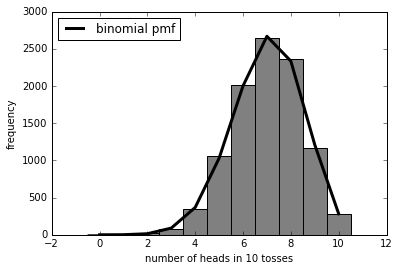

In [64]:
import scipy.stats as stats
Nexp=10000 # repeat the experiment 10,000 times
nheads = np.zeros(Nexp) # array to hold the result of each experiment
N=10
#Conduct the Nexp experiments:
for i in range(Nexp):
    #A single experiment
    r = np.random.uniform(0.0,1.0,N)
    #Count how many are smaller than 0.7, add to array of results
    nheads[i] = r[r<0.7].size    
    
#Plot the result:
bins=np.linspace(-0.5,N+0.5,N+2)
pl.hist(nheads,bins=bins, color='gray')
pl.xlabel("number of heads in 10 tosses")
pl.ylabel("frequency")
#Plot the binomial distribution
norm = Nexp/(bins[1]-bins[0]) #normalization, since the histogram is not normalized
xi=np.arange(N+1)
pl.plot(xi,norm*stats.binom.pmf(xi,N,0.7),color='black',lw=3,label='binomial pmf')
pl.legend(loc='best')
pl.show()

### Simulating a poutine restaurant
We now simulate a more complex situation, namely the distribution of profits expected in our poutine restaurant if we stay open an extra hour.

Mean profits: $46.08


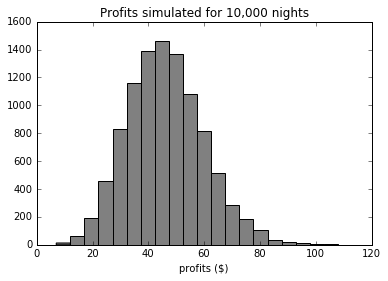

In [75]:
Nexp = 10000 # the number of experiments (nights)
profits = np.zeros(Nexp)# array to hold the profits for each night
#Perform Nexp experiments
for iexp in range(Nexp):
    #For each night:
    #Generate a random number of customers with (Poisson) mean 15
    ncustomers = np.random.poisson(15)
    #For each customer, simulate their order:
    for icustomer in range(ncustomers):
        #Generate a random number of poutines with Poisson mean of 1
        #Repeat until the number is bigger than 0
        npoutines=0
        while(npoutines<1):
            npoutines = np.random.poisson(1)
        #For each poutine, decide what type it is
        for ipoutine in range(npoutines):
            #Draw a uniform random number between 0 and 1 for the choice
            choice = np.random.uniform()
            #based on the type, add in the profits for that night:
            if choice<0.7: #traditional
                profits[iexp] = profits[iexp]+2.00 
            elif choice>=0.7 and choice <0.9:#pork
                profits[iexp] = profits[iexp]+2.50 
            else:#vegetarian
                profits[iexp] = profits[iexp]+0.50
                
print("Mean profits: ${:.2f}".format(profits.mean())) 
#Plot it:
pl.hist(profits,bins=20,color='gray')
pl.xlabel('profits ($)')
pl.title('Profits simulated for 10,000 nights')
pl.show()

### Monte Carlo simulation for error propagation

We wish to examine the error on the Coulomb force:
$$F = k\frac{q_1q_2}{r^2}$$
when we have measured $q_1$, $q_2$, and $r$

Starting with the derivative formula and 1% errors on all measurements:

In [1]:
import numpy as np
import pylab as pl
import sympy as sym
%matplotlib inline

#Measured (or numerical) values:
k_meas = 9e9 #constant
#Measured values with 1% relative errors
q1_meas = 1e-6
sigma_q1_meas = 0.01*q1_meas
q2_meas = 2e-5
sigma_q2_meas = 0.01*q2_meas
r_meas = 0.1
sigma_r_meas = 0.01*r_meas

#Define symbols
k,q1,q2,r,sigma_q1,sigma_q2,sigma_r= sym.symbols('k, q_1 q_2 r sigma_{q1} sigma_{q2} sigma_{r}')
#F and its uncertainty
F = k*q1*q2/r**2
sigma_F =sym.sqrt((sym.diff(F,q1)*sigma_q1)**2+ (sym.diff(F,q2)*sigma_q2)**2+ (sym.diff(F,r)*sigma_r)**2)
values = [(k,k_meas),(q1,q1_meas),(q2,q2_meas),(r,r_meas),
          (sigma_q1,sigma_q1_meas),(sigma_q2,sigma_q2_meas),(sigma_r,sigma_r_meas)]
F_val = F.subs(values)
sigma_F_val = sigma_F.subs(values)
print("Using error propagation, the force is:")
print("F = {:.2f} +/ {:.2f} N".format(F_val,sigma_F_val))


Using error propagation, the force is:
F = 18.00 +/ 0.44 N


Now, using Monte Carlo simulation:

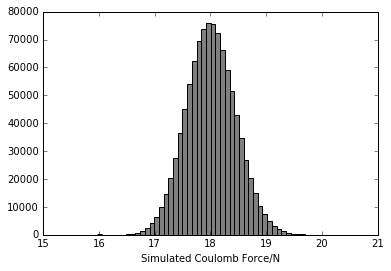

In [2]:
#Generate normally distributed values of r, q1, q2 about their measured values:
N = 1000000 # number of MC samples
#randomly distributed values of q1, q2, and r:
r_sim = np.random.normal(r_meas,sigma_r_meas,N)
q1_sim = np.random.normal(q1_meas,sigma_q1_meas,N)
q2_sim = np.random.normal(q2_meas,sigma_q2_meas,N)

#Generate the corresponding values for the force:
F_sim = k_meas*q1_sim*q2_sim/r_sim**2

#Plot a histogram of the simulated values of F
pl.hist(F_sim,bins=50,color='gray')
pl.xlabel("Simulated Coulomb Force/N")
pl.show()


The distribution of $F$ is quite gaussian, as we would anticipate if the Taylor series is a valid approximation to F. We can thus define our MC estimate of $F$ using the mean and standard deviation of the simulated values:

In [3]:
print("Using Monte Carlo simulation mean and standard deviation, the force is:")
print("F = {:.2f} +/ {:.2f} N".format(F_sim.mean(),F_sim.std(ddof=1)))

Using Monte Carlo simulation mean and standard deviation, the force is:
F = 18.01 +/ 0.44 N


which agrees nicely with the value from the error propagation with the derivatives.

Now, let's examine what happens when we increase all of the error by a factor of 10, from 1% relative error to 10% relative errors.

Using error propagation, the force is:
F = 18.00 +/ 4.41 N


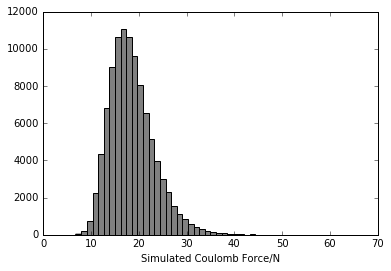

Using Monte Carlo simulation mean and standard deviation, the force is:
F = 18.57 +/ 4.76 N


In [4]:
q1_meas = 1e-6
sigma_q1_meas = 0.1*q1_meas
q2_meas = 2e-5
sigma_q2_meas = 0.1*q2_meas
r_meas = 0.1
sigma_r_meas = 0.1*r_meas

#Define symbols
k,q1,q2,r,sigma_q1,sigma_q2,sigma_r= sym.symbols('k, q_1 q_2 r sigma_{q1} sigma_{q2} sigma_{r}')
#F and its uncertainty
F = k*q1*q2/r**2
sigma_F =sym.sqrt((sym.diff(F,q1)*sigma_q1)**2+ (sym.diff(F,q2)*sigma_q2)**2+ (sym.diff(F,r)*sigma_r)**2)
values = [(k,k_meas),(q1,q1_meas),(q2,q2_meas),(r,r_meas),
          (sigma_q1,sigma_q1_meas),(sigma_q2,sigma_q2_meas),(sigma_r,sigma_r_meas)]
F_val = F.subs(values)
sigma_F_val = sigma_F.subs(values)
print("Using error propagation, the force is:")
print("F = {:.2f} +/ {:.2f} N".format(F_val,sigma_F_val))

#Generate normally distributed values of r, q1, q2 about their measured values:
N = 100000 # number of MC samples
#randomly distributed values of q1, q2, and r:
r_sim = np.random.normal(r_meas,sigma_r_meas,N)
q1_sim = np.random.normal(q1_meas,sigma_q1_meas,N)
q2_sim = np.random.normal(q2_meas,sigma_q2_meas,N)

#Generate the corresponding values for the force:
F_sim = k_meas*q1_sim*q2_sim/r_sim**2

#Plot a histogram of the simulated values of F
pl.hist(F_sim,bins=50,color='gray')
pl.xlabel("Simulated Coulomb Force/N")
pl.show()

print("Using Monte Carlo simulation mean and standard deviation, the force is:")
print("F = {:.2f} +/ {:.2f} N".format(F_sim.mean(),F_sim.std(ddof=1)))

Using the mode of F and an uncertainty with 68% coverage:

Using Monte Carlo mode and 68% confidence:
The force is 16.21 +/- 4.69 N, with 70.2% confidence


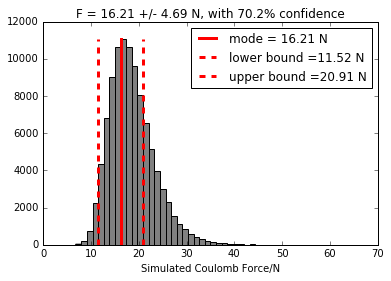

In [22]:
#Histogram the values and keep the counts in each bin
n,bins,patches = pl.hist(F_sim,bins=50,color='gray')
#Find the index of the bin with the highest content (The mode)
n_max =n.max()
index = (np.abs(n-n_max)).argmin()
#The corresponding value of the force
best_F = bins[index]
#Iterate to find the 68% coverage
d=0 # add or subtract d iteratively to index to cover larger ranges of the histogram
area = n[index-d:index+d].sum()/n.sum() #area between index-d and index+d

while area < 0.68: #normlalize area each time it's calculated
    d = d+1
    area = n[index-d:index+d].sum()/n.sum()
 
sigma_F = best_F-bins[index-d]

print("Using Monte Carlo mode and 68% confidence:")
print("The force is {:.2f} +/- {:.2f} N, with {:.1f}% confidence".format(best_F,sigma_F,100*area))

pl.plot([best_F,best_F],[0,n_max],color='red',lw=3,label='mode = {:.2f} N'.format(best_F))
pl.plot([best_F-sigma_F,best_F-sigma_F],[0,n_max],'--',color='red',lw=3,label='lower bound ={:.2f} N'.format(best_F-sigma_F))
pl.plot([best_F+sigma_F,best_F+sigma_F],[0,n_max],'--',color='red',lw=3,label='upper bound ={:.2f} N'.format(best_F+sigma_F))
pl.xlabel("Simulated Coulomb Force/N")
pl.title("F = {:.2f} +/- {:.2f} N, with {:.1f}% confidence".format(best_F,sigma_F,100*area))
pl.legend()
pl.show()


In [13]:
t=np.linspace(0,10,11)
t[1:3]

array([ 1.,  2.])